In [25]:
#%pip install gurobipy

In [26]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import gurobipy as gp
from gurobipy import GRB
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LassoCV

## Optimization model

We want to decide the price of 11 products to maximize the Category Revenue of orange juice in a superstore. 

#### Variables:

$p_i$: Price of product $i$

$q_i$: Predicted demand for product $i$ considering prices and elasticities between products.

#### Constraints:
- $preciomin_i$: minimun historical price of product $i$ 

- $preciomax_i$: maximun historical price of product $i$

- Average price of category can change up to 10%:
\begin{align}
\textrm{mean(Prices)} * 0.9 \leq \textrm{mean}\left(\sum_{i} p_i\right) \leq \textrm{mean(Prices)} * 1.1 \nonumber
\end{align}

#### Objective Function:

\begin{align}
\textrm {maximize} &  \sum_{i}  (p_i * q_i)& \nonumber
\end{align}

## Optimizing with 11 products 

The data used is the Store-Level Panel Data on Orange Juice Sales from Bayesm library in R, which contains weekly sales of refrigerated orange juice at 83 stores. We will focus on store 2.

The data provides the logarithm of demand, the price, the status of deal (coupon activity) and feature advertisement for each product each week. 


In [27]:
data=pd.read_csv("Orangejuice.csv")

#only using store numer 2 
data_store2=data[data["store"]== 2]

nprod=11 #this number can be set between 1 and 11 and it will work
n=list()#list with index of products
for i in range(1, nprod+1):
    n.append(i)

# to get log move (log demand) for every product each week
log_move = data_store2.pivot(index='week', columns='brand', values='logmove')
log_move.reset_index(inplace=True)
log_move=log_move[n] #log demanda

deal = data_store2.pivot(index='week', columns='brand', values='deal')
deal.reset_index(inplace=True)
deal=deal[n] 

feat = data_store2.pivot(index='week', columns='brand', values='feat')
feat.reset_index(inplace=True)
feat=feat[n] 

col_log_move=[] #column names logdemand for all the products
col_prices=[]#column names price for all the products
col_logprices =[] #for logprice
col_deal=[] #for deal, coupon 
col_feat=[] # for feat, feature advertisement
for i in n:
    col_log_move.append(f"Logdemand{i}")
    col_prices.append(f"price{i}")
    col_logprices.append(f"Logprice{i}")
    col_deal.append(f"Deal{i}")
    col_feat.append(f"Feat{i}")

log_move.columns=col_log_move
deal.columns=col_deal
feat.columns=col_feat

Prices=data_store2[col_prices] 
lp=np.log(Prices)
lp.columns=col_logprices

demanda= pd.concat([log_move, lp, deal, feat], axis=1)
demanda=pd.DataFrame(demanda.dropna())

To predict the demand of each product we consider the prices, deal and feat of each product to do a linear regression for each product.

We also make a function to calculate the revenue the prices of the products

In [28]:
model_dict = {}
price_term = ' + '.join(col_logprices+col_deal+col_feat)

for i in range(1, nprod + 1):
    formula = f"demanda['Logdemand{i}'] ~ {price_term}"
    modelo = smf.ols(formula, data=demanda).fit()
    model_dict[f'm_{i}'] = modelo

def f_venta(Precio):
    lp = pd.DataFrame(np.array(Precio))
    lp.columns = col_logprices +col_deal+col_feat
    lp[col_logprices]=np.log(lp[col_logprices])
    venta = 0
    for i in range(1, nprod + 1):
        v = Precio[i-1] * np.round(np.exp(model_dict[f'm_{i}'].predict(lp)))
        venta = venta + v
    return np.array(venta)[0] 

We formulate the optimization problem in gurobi

In [29]:
m= gp.Model("Orange Juice Prices")
Prices=np.array(Prices)

ci=[np.mean(np.mean(Prices,axis=1))*nprod*0.9, np.mean(np.mean(Prices, axis=0))*nprod*1.1] #rewriting ci for the constraint
preciomin = np.nanmin(Prices, axis=0)
preciomax=np.nanmax(Prices, axis=0)

#bounds
precio_min={i: preciomin[i-1] for i in n} 
precio_max={i: preciomax[i-1] for i in n} 
log_min={i: np.log(precio_min[i]) for i in n}
log_max={i: np.log(precio_max[i]) for i in n}

p= m.addVars(n, name="p", lb=precio_min, ub=precio_max)
log_p=m.addVars(n, name="log_p", lb= log_min, ub=log_max)
log_q = m.addVars(n, name="log_q", lb=0)
q = m.addVars(n, name="q", lb=0) 

for i in n:
    m.addGenConstrExp(log_p[i], p[i]) #add constraint for consistency between log(p) and p
    m.addGenConstrExp(log_q[i], q[i])

m.addConstr(sum((p[i] for i in n)) >= ci[0])
m.addConstr(sum((p[i] for i in n)) <= ci[1])

#To calculate the predicted demand per product
for i in n:
    coef=model_dict[f"m_{i}"].params.to_dict() 
    pred=coef["Intercept"]+ sum((coef[f"Logprice{i}"]*log_p[i] for i in n)) #we are assuming  that deal=0 and feast=0
    m.addConstr(log_q[i]==pred) 

m.setObjective(sum((p[i]*q[i] for i in n)))
m.ModelSense = GRB.MAXIMIZE

m.Params.NonConvex = 2
m.optimize()

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 13 rows, 44 columns and 154 nonzeros
Model fingerprint: 0x54b1ea71
Model has 11 quadratic objective terms
Model has 22 general constraints
Variable types: 44 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-03, 4e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [2e-02, 4e+00]
  RHS range        [4e-01, 9e+00]
Presolve added 55 rows and 3220 columns
Presolve time: 0.01s
Presolved: 91 rows, 3276 columns, 9906 nonzeros
Presolved model has 22 SOS constraint(s)
Presolved model has 11 bilinear constraint(s)


Variable types: 3276 continuous, 0 integer (0 binary)

Root relaxation: objective 2.919078e+04, 200 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 29190.7809    0   21          - 29190.7809      -     -    0s
     0     0 29190.7809    0   21          - 29190.7809      -     -    0s
     0     2 29190.7809    0   21          - 29190.7809      -     -    0s
H  538   388                    3222.8822149 27780.2243   762%   5.6    0s
H 1109   739                    3302.1854193 27780.2243   741%   5.2    1s
H 1246   850                    3302.7577231 27780.2243   741%   5.1    1s
H 1256   834                    3419.8696232 27780.2243   712%   5.1    1s
* 1356   867             164    3419.9131895 27780.2243   712%   5.0    1s
H 1526   908                    3420.8477180 27780.2243   712%   5.1    1s
H 2479  1117                  

In [30]:
solution = pd.DataFrame()
Preciolast=np.array(Prices)[-1,:]
Preciolast_df=pd.DataFrame(Preciolast).T
Preciolast_df[col_deal]=0
Preciolast_df[col_feat]=0
demandlast=np.array(np.exp(log_move))[-1,:]
opt_revenue = m.ObjVal

solution['Product'] = n
solution['Last Price'] = Preciolast
solution['Last demand']=demandlast
solution['Last Sales']=demandlast*Preciolast
solution['Price opt'] = [(p[i].X) for i in n]
solution['Demand opt'] = [(q[i].X) for i in n]
solution['Sales opt'] = [(q[i].X * p[i].X) for i in n]
solution['Change in Price'] =[f"{(round((p[i].X-Preciolast[i-1])*100/Preciolast[i-1],1))}%" for i in n]

print(f"Category revenue after optimization: {round(opt_revenue,2)}")
print(f"Category Revenue before optimization: {round(f_venta(Preciolast_df),2)}")
print(f"% of Change of revenue after optimization: {round((opt_revenue-f_venta(Preciolast_df))/f_venta(Preciolast_df)*100,2)}%")

solution=solution.round(3)
display(solution)

Category revenue after optimization: 7646.83
Category Revenue before optimization: 2283.21
% of Change of revenue after optimization: 234.92%


,Product,Last Price,Last demand,Last Sales,Price opt,Demand opt,Sales opt,Change in Price
0,1,0.046,5824.0,270.270,0.026,14807.988,391.023,-43.1%
1,2,0.042,8256.0,343.140,0.037,15730.481,588.254,-10.0%
2,3,0.047,1280.0,59.800,0.052,749.500,39.232,12.0%
3,4,0.043,1984.0,85.560,0.048,2352.177,112.463,10.9%
4,5,0.034,41216.0,1410.360,0.050,3887.350,192.545,44.7%
5,6,0.037,1824.0,67.323,0.053,658.115,34.894,43.6%
6,7,0.040,384.0,15.540,0.018,22996.766,406.037,-56.4%
7,8,0.032,1792.0,57.960,0.018,3132.304,55.305,-45.4%
8,9,0.037,704.0,26.290,0.048,46.878,2.256,28.9%
9,10,0.028,8640.0,245.700,0.015,366776.096,5673.568,-45.6%


## Comparing with constrOptim optimization in r

To our previous optimization model in Gurobi we add a Callback function to store the incumbent value and the time that has passed till that point, with this we will be able to graph the progress of the solver.

In [31]:
current_z=[]
z_time=[]
def MIPSOL_OBJBST_Callback11(model, where): #callback to have store each incumbent found
    if where == GRB.Callback.MIPSOL:
        obj_jbst = model.cbGet(GRB.Callback.MIPSOL_OBJBST)#gets the current incumbent value
        current_z.append(obj_jbst) #saves it on a list
        current_runtime = model.cbGet(GRB.Callback.RUNTIME)#gets the time that the optimization has been running
        z_time.append(current_runtime/60) #to make it in minutes

m_graph= gp.Model("Orange Juice Prices with 11 products")


Prices=np.array(Prices)

ci=[np.mean(np.mean(Prices,axis=1))*nprod*0.9, np.mean(np.mean(Prices, axis=0))*nprod*1.1] #rewriting ci for the constraint
preciomin = np.nanmin(Prices, axis=0)
preciomax=np.nanmax(Prices, axis=0)

#bounds
precio_min={i: preciomin[i-1] for i in n} 
precio_max={i: preciomax[i-1] for i in n} 
log_min={i: np.log(precio_min[i]) for i in n}
log_max={i: np.log(precio_max[i]) for i in n}

p= m_graph.addVars(n, name="p", lb=precio_min, ub=precio_max)
log_p=m_graph.addVars(n, name="log_p", lb= log_min, ub=log_max)
log_q = m_graph.addVars(n, name="log_q", lb=0)
q = m_graph.addVars(n, name="q", lb=0) 

for i in n:
    m_graph.addGenConstrExp(log_p[i], p[i]) #add constraint for consistency between log(p) and p
    m_graph.addGenConstrExp(log_q[i], q[i])
m_graph.addConstr(sum((p[i] for i in n)) >= ci[0])
m_graph.addConstr(sum((p[i] for i in n)) <= ci[1])

for i in n:
    coef=model_dict[f"m_{i}"].params.to_dict() #m_i considers the log of demand 
    pred=coef["Intercept"]+ sum((coef[f"Logprice{i}"]*log_p[i] for i in n)) #we are assuming  that deal=0 and feast=0
    m_graph.addConstr(log_q[i]==pred) 

m_graph.setObjective(sum((p[i]*q[i] for i in n)))
m_graph.ModelSense = GRB.MAXIMIZE

m_graph.Params.NonConvex = 2

m_graph.optimize(MIPSOL_OBJBST_Callback11)
time=m_graph.runtime#to know the total time 
current_z[0]=0 #since gurobi is using branch and bound, the firts incumbent is -1000000, so we change it to 0 to be able to graph it better

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 13 rows, 44 columns and 154 nonzeros
Model fingerprint: 0x54b1ea71
Model has 11 quadratic objective terms
Model has 22 general constraints
Variable types: 44 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-03, 4e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [2e-02, 4e+00]
  RHS range        [4e-01, 9e+00]


Presolve added 55 rows and 3220 columns
Presolve time: 0.02s
Presolved: 91 rows, 3276 columns, 9906 nonzeros
Presolved model has 22 SOS constraint(s)
Presolved model has 11 bilinear constraint(s)
Variable types: 3276 continuous, 0 integer (0 binary)

Root relaxation: objective 2.919078e+04, 200 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 29190.7809    0   21          - 29190.7809      -     -    0s
     0     0 29190.7809    0   21          - 29190.7809      -     -    0s
     0     2 29190.7809    0   21          - 29190.7809      -     -    0s
H  538   388                    3222.8822149 27780.2243   762%   5.6    0s
H 1109   739                    3302.1854193 27780.2243   741%   5.2    1s
H 1246   850                    3302.7577231 27780.2243   741%   5.1    1s
H 1256   834                    3419.8696232 27780.2243   7

Using R, we optimize the same model using constrOptim and linear regression, since a high number of iterations takes a long time, I have exported the R results into a csv, now we will import it to python to be able to compare it to gurobi optimization in the same graph.

The code used in R is based on Florencia Vidal's code which compared different solvers in R for the same optimization model but considering 4 products instead of 11.

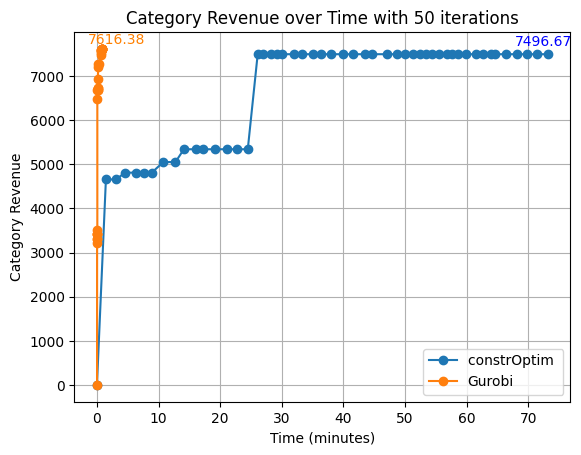

In [32]:
dataR=pd.read_csv("data11dfGraphR_iter50.csv")
row0 = pd.DataFrame([[0]*len(dataR.columns)], columns=dataR.columns)
dataR = pd.concat([row0, dataR], ignore_index=True)
plt.plot(dataR["time_iter"], dataR["pi_incumbent"], marker='o', linestyle='-', label="constrOptim ")
plt.plot(z_time, current_z, marker='o', linestyle='-', label="Gurobi")

last_point_R = (dataR["time_iter"].iloc[-1], dataR["pi_incumbent"].iloc[-1])
plt.annotate(f'{last_point_R[1]:.2f}', last_point_R, textcoords="offset points", xytext=(-24, 6), ha='left', color="blue")

last_point_Gurobi = (z_time[-1], current_z[-1])
plt.annotate(f'{last_point_Gurobi[1]:.2f}', last_point_Gurobi, textcoords="offset points", xytext=(-10, 3.5), ha='left', color=(255/255, 128/255,0))

plt.title('Category Revenue over Time with 50 iterations')
plt.xlabel('Time (minutes)')
plt.ylabel('Category Revenue')
plt.legend()
plt.grid(True)
plt.show()

Since we know that the incumbent was found in iteration 16, we make a new graph that with 17 iterations

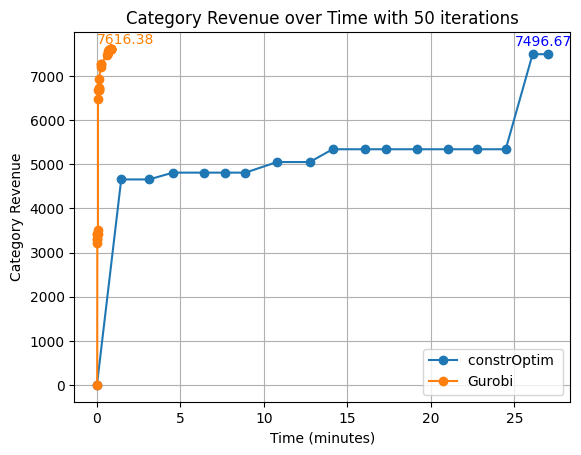

In [33]:
dataR=(pd.read_csv("data11dfGraphR_iter50.csv")).head(17)
row0 = pd.DataFrame([[0]*len(dataR.columns)], columns=dataR.columns)
dataR = pd.concat([row0, dataR], ignore_index=True)
plt.plot(dataR["time_iter"], dataR["pi_incumbent"], marker='o', linestyle='-', label="constrOptim ")
plt.plot(z_time, current_z, marker='o', linestyle='-', label="Gurobi")

last_point_R = (dataR["time_iter"].iloc[-1], dataR["pi_incumbent"].iloc[-1])
plt.annotate(f'{last_point_R[1]:.2f}', last_point_R, textcoords="offset points", xytext=(-24, 6), ha='left', color="blue")

last_point_Gurobi = (z_time[-1], current_z[-1])
plt.annotate(f'{last_point_Gurobi[1]:.2f}', last_point_Gurobi, textcoords="offset points", xytext=(-10, 3.5), ha='left', color=(255/255, 128/255,0))

plt.title('Category Revenue over Time with 50 iterations')
plt.xlabel('Time (minutes)')
plt.ylabel('Category Revenue')
plt.legend()
plt.grid(True)
plt.show()

## Lasso regression

Now we use Lasso regression instead of linear regression to predict the demand to male the result more realistic. 

Using cross validation we define the best alpha for each Lasso regression.

In [34]:
dict = {}
score=[]
for i in n:
    y = demanda[f'Logdemand{i}']
    X = demanda[col_logprices]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=30)
    model = LassoCV(cv=5, random_state=20, max_iter=10000)
    model.fit(X_train, y_train)
    LassoCV(cv=5, max_iter=10000, random_state=0)
    lasso = Lasso(alpha=model.alpha_)
    lasso.fit(X_train, y_train)
    score.append(lasso.score(X_train, y_train))
    dict[f"m_{i}"]=lasso

def f_venta_lasso(precio): #f venta with lasso regression
    lp = pd.DataFrame(np.array(precio))
    lp.columns = col_logprices +col_deal+col_feat
    lp[col_logprices]=np.log(lp[col_logprices])
    venta = 0
    for i in n:
        coef=dict[f"m_{i}"]
        pred=coef.intercept_ +sum((coef.coef_[j]*lp.iloc[0,j] for j in range(0, nprod)))
        v = precio[i-1]* np.exp(pred)
        venta = venta + v
    return np.array(venta)[0]

Now we compare the mean absolute percentage error between the prediction with Linear Regression and Lasso Regression

In [35]:
demandpred=pd.DataFrame()
Prices=data_store2[col_prices] 
Prices_df=pd.DataFrame((pd.concat([Prices, deal, feat], axis=1)).dropna())
Preciolast_df=np.array(Prices_df)[-1,:]
demandlast=np.array(np.exp(log_move))[-1,:]

demandpred["Product"]=n
demandpred["Last Demand"]=demandlast

LRpred=[]
for j in n:
    coef=model_dict[f"m_{j}"].params.to_dict() 
    pred=coef["Intercept"]+ sum((coef[f"Logprice{i}"]*np.log(Preciolast_df[i-1]) for i in n)) #we are assuming  that deal=0 and feast=0
    LRpred.append(np.exp(pred))
demandpred["Linear Prediction"]=LRpred

lassopred=[]
for j in n:
    coef=dict[f"m_{j}"]
    pred=coef.intercept_ +sum((coef.coef_[i-1]*np.log(Preciolast_df[i-1]) for i in n))
    lassopred.append(np.exp(pred))
demandpred["Lasso Prediction"]=lassopred



mape_lr=mean_absolute_percentage_error(demandpred["Last Demand"], demandpred["Linear Prediction"])
mape_lasso=mean_absolute_percentage_error(demandpred["Last Demand"], demandpred["Lasso Prediction"])
print(f"MAPE linear regression: {round(mape_lr*100,2)}%")
print(f"MAPE lasso: {round(mape_lasso*100, 2)}%")
demandpred=demandpred.round(2)
display(demandpred)


MAPE linear regression: 95.1%
MAPE lasso: 76.8%


,Product,Last Demand,Linear Prediction,Lasso Prediction
0,1,5824.0,9896.13,9865.37
1,2,8256.0,11212.79,10639.97
2,3,1280.0,1571.64,2097.82
3,4,1984.0,2310.27,2907.47
4,5,41216.0,10301.28,12814.83
5,6,1824.0,4553.30,3990.08
6,7,384.0,2145.18,1929.56
7,8,1792.0,2732.53,1957.24
8,9,704.0,1546.28,797.29
9,10,8640.0,9775.08,7939.94


Now we optimize using the lasso regression

In [38]:
m_Lasso= gp.Model("Orange Juice Prices using Lasso")
Prices=np.array(Prices)

ci=[np.mean(np.mean(Prices,axis=1))*nprod*0.9, np.mean(np.mean(Prices, axis=0))*nprod*1.1] #rewriting ci for the constraint
preciomin = np.nanmin(Prices, axis=0)
preciomax=np.nanmax(Prices, axis=0)

#bounds
precio_min={i: preciomin[i-1] for i in n} 
precio_max={i: preciomax[i-1] for i in n} 
log_min={i: np.log(precio_min[i]) for i in n}
log_max={i: np.log(precio_max[i]) for i in n}

p= m_Lasso.addVars(n, name="p", lb=precio_min, ub=precio_max)
log_p=m_Lasso.addVars(n, name="log_p", lb= log_min, ub=log_max)
log_q = m_Lasso.addVars(n, name="log_q", lb=0)
q = m_Lasso.addVars(n, name="q", lb=0) 

for i in n:
    m_Lasso.addGenConstrExp(log_p[i], p[i]) #add constraint for consistency between log(p) and p
    m_Lasso.addGenConstrExp(log_q[i], q[i])

m_Lasso.addConstr(sum((p[i] for i in n)) >= ci[0])
m_Lasso.addConstr(sum((p[i] for i in n)) <= ci[1])

#prediction of demand
for i in n:
    coef=dict[f"m_{i}"]
    pred=coef.intercept_ +sum((coef.coef_[i-1]*log_p[i] for i in n))
    m_Lasso.addConstr(log_q[i]==pred) 

m_Lasso.setObjective(sum((p[i]*q[i] for i in n)))
m_Lasso.ModelSense = GRB.MAXIMIZE

m_Lasso.Params.NonConvex = 2
m_Lasso.optimize()

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 13 rows, 44 columns and 101 nonzeros
Model fingerprint: 0xecf49cac
Model has 11 quadratic objective terms
Model has 22 general constraints
Variable types: 44 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-03, 4e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [2e-02, 4e+00]
  RHS range        [4e-01, 8e+00]
Presolve added 55 rows and 3222 columns
Presolve time: 0.02s
Presolved: 91 rows, 3278 columns, 9859 nonzeros
Presolved model has 22 SOS constraint(s)
Presolved model has 11 bilinear constraint(s)
Variable types: 3278 continuous, 0 integer (0 binary)

Root relaxation: objective 1.470495e+04, 186 iterations, 0.01 seconds (0.01 work units)

     0     0 14704.9465    0   29          - 14704.9465      -     -    0s
     0     2 14704.9465    0   29          - 14704.9465      -     -    0s
H 1109   688                    2519.7930775 13982.6396   455%   3.9    0s
H 1126   679                    2786.4741299 13982.6396   402%   3.9    0s
* 1612   940             185    2786.6741506 13982.6396   402%   3.6    1s
* 1674   781             186    3179.3578885 13982.6396   340%   3.5    1s
H 1764   799                    3179.7938187 13982.6396   340%   3.8    1s
H 1765   799                    3180.2970411 13982.6396   340%   3.8    1s
H 2649  1001                    4010.2354790 9865.69975   146%   7.1    2s
H 2931  1063                    4010.3470129 9514.81665   137%   7.3    3s
* 3163  1070             164    4010.4067716 9009.61824   125%   7.6    3s
H 3601  1040                    4354.6182169 8994.27987   107%   7.7    3s
H 3757  1089                    4354.8601706 8862.01888   103%   7.7    4s
  4075  1431 5546.89553  

In [39]:
solution_lasso = pd.DataFrame()
Preciolast=np.array(Prices)[-1,:]
Preciolast_df=pd.DataFrame(Preciolast).T
Preciolast_df[col_deal]=0
Preciolast_df[col_feat]=0
opt_revenue_lasso = m_Lasso.ObjVal

solution_lasso['Product'] = n
solution_lasso['Last Price'] = Preciolast
solution_lasso['Last demand']=demandlast
solution_lasso['Last Sales']=demandlast*Preciolast
solution_lasso['Price opt'] = [(p[i].X) for i in n]
solution_lasso['Demand opt'] = [(q[i].X) for i in n]
solution_lasso['Sales opt'] = [(q[i].X * p[i].X) for i in n]
solution_lasso['Change in Price'] =[f"{(round((p[i].X-Preciolast[i-1])*100/Preciolast[i-1],1))}%" for i in n]


print(f"Category revenue after optimization: {round(opt_revenue_lasso,2)}")
print(f"Category Revenue before optimization: {round(f_venta_lasso(Preciolast_df),2)}")
print(f"% of Change of revenue after optimization: {round((opt_revenue_lasso-f_venta_lasso(Preciolast_df))/f_venta_lasso(Preciolast_df)*100,2)}%")
print(f"% of Change of revenue with Lasso vs linear regression: {round((opt_revenue_lasso-opt_revenue)/opt_revenue*100,2)}%")
print(f"Category revenue afeter optimization with linear regression: {round(opt_revenue,2)}")

solution_lasso=solution_lasso.round(3)
display(solution_lasso)

Category revenue after optimization: 5320.25
Category Revenue before optimization: 2239.64
% of Change of revenue after optimization: 137.55%
% of Change of revenue with Lasso vs linear regression: -30.43%
Category revenue afeter optimization with linear regression: 7646.83


,Product,Last Price,Last demand,Last Sales,Price opt,Demand opt,Sales opt,Change in Price
0,1,0.046,5824.0,270.270,0.060,3512.855,212.418,30.3%
1,2,0.042,8256.0,343.140,0.060,6749.785,408.339,45.6%
2,3,0.047,1280.0,59.800,0.025,22345.253,548.157,-47.5%
3,4,0.043,1984.0,85.560,0.023,94871.097,2208.718,-46.0%
4,5,0.034,41216.0,1410.360,0.050,921.409,45.639,44.7%
5,6,0.037,1824.0,67.323,0.053,1718.578,91.120,43.6%
6,7,0.040,384.0,15.540,0.018,45243.542,798.831,-56.4%
7,8,0.032,1792.0,57.960,0.042,798.716,33.571,30.0%
8,9,0.037,704.0,26.290,0.048,322.997,15.544,28.9%
9,10,0.028,8640.0,245.700,0.015,55477.672,858.170,-45.6%
